# Project 3
The prediction of molecular properties is an important task in drug discovery. The molecules' atomic composition and arrangement can be very informative of their biological behavior. Each 2D molecule can be represented as a graph, where the nodes are atoms connected by edges corresponding to chemical bonds. The prediction of molecular properties can be formulized as a graph classification task.

In this project, we train a graph neural network to perform binary classifications on 12 molecular properties.

# Install packages

In [ ]:
!pip install torch_geometric --quiet
!pip install rdkit-pypi --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 50.4 MB/s eta 0:00:00


# Load Dataset

In [ ]:
import torch
import torch_geometric
import numpy as np
import pandas as pd
from torch_geometric.data import Data
from torch_geometric.data import DataLoader
from torch_geometric.datasets import MoleculeNet

In [ ]:
train_dataset = torch.load("Data/train_data.pt")
valid_dataset = torch.load("Data/valid_data.pt")
test_dataset = torch.load("Data/test_data.pt")

print(f'Size of training set: {len(train_dataset)}')
print(f'Size of validation set: {len(valid_dataset)}')
print(f'Size of test set: {len(test_dataset)}')

Size of training set: 6264
Size of validation set: 783
Size of test set: 784


## Extract Fingerprint

In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem

FINGERPRINT_SIZE = 2048

def generate_morgan_fingerprint(molecule, radius=2, n_bits=FINGERPRINT_SIZE):
    mol = Chem.MolFromSmiles(molecule)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    return torch.tensor(list(fp), dtype=torch.float32)

for data in train_dataset:
  data.fingerprint = generate_morgan_fingerprint(data.smiles)
for data in valid_dataset:
  data.fingerprint = generate_morgan_fingerprint(data.smiles)
for data in test_dataset:
  data.fingerprint = generate_morgan_fingerprint(data.smiles)

[18:45:26] WARNING: not removing hydrogen atom without neighbors


## Class Weights

In [ ]:
y = [g.y for g in train_dataset]
y = [np.array(x[0]) for x in y]
y = pd.DataFrame(y, columns = np.arange(1, 13))

class_sizes = []
for i in range(1, 13):
  class_sizes.append(y[i].dropna().size)

class_weights = y.sum()/(class_sizes - y.sum())
class_weights = np.array(1/class_weights)

## Batching

In [ ]:
from torch_geometric.loader import DataLoader

batch_size=64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Build Model

In [ ]:
import torch.nn as nn
from torch_geometric.nn.conv import GATConv
from torch_geometric.nn import global_mean_pool as gap
import torch.nn.functional as F
from torch.nn import Linear

class AtomEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, num_node_features, embedding_size):
        super(AtomEncoder, self).__init__()
        self.embeddings = torch.nn.ModuleList()

        for i in range(num_node_features):
            self.embeddings.append(torch.nn.Embedding(embedding_size, hidden_channels))

    def reset_parameters(self):
        for embedding in self.embeddings:
            embedding.reset_parameters()

    def forward(self, x):
        if x.dim() == 1:
            x = x.unsqueeze(1)

        out = 0
        for i in range(x.size(1)):
            out += self.embeddings[i](x[:, i])
        return out


class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, num_node_features, num_classes, heads=1,
                 dropout=0.3,internal_dropout = (0.2,0.2,0.2), embedding_size=100):
        super(GAT, self).__init__()
        torch.manual_seed(42)

        self.emb = AtomEncoder(hidden_channels, num_node_features, embedding_size)

        self.conv1 = GATConv(hidden_channels, hidden_channels, heads=heads, dropout=internal_dropout[0])
        self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=heads, dropout=internal_dropout[1])
        self.conv3 = GATConv(hidden_channels * heads, hidden_channels, heads=heads, dropout=internal_dropout[2])

        self.dropout = dropout

        self.lin1 = Linear(hidden_channels*heads + FINGERPRINT_SIZE, 64)
        self.lin2 = Linear(64, num_classes)

    def forward(self, batch):
        x, edge_index, batch_size, fingerprint = batch.x, batch.edge_index, batch.batch, batch.fingerprint

        # 1. Obtain node embeddings
        x = self.emb(x)

        # 2. Apply GAT layers
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index) + x)
        x = F.relu(self.conv3(x, edge_index) + x)

        # 3. Readout layer
        x = gap(x, batch_size)
        fingerprint = fingerprint.view(-1, FINGERPRINT_SIZE)
        x = torch.cat([x, fingerprint], dim=1)

        # 4. Apply a final classifier
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lin1(x)
        x = self.lin2(x)

        return x

### Create Model

In [ ]:
model = GAT(128, 9, 12, heads=6)

# out = model(batch)
# print(out.shape)    # (num_of_graph, num_of_task)

# Train Model

## Optimizer & Loss Function

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Overweighting to equalize negative/positive classes
criterion = [0]*len(class_weights)
for i in range(len(class_weights)):
  criterion[i] = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(class_weights[i]))

## Training & Evaluation

In [ ]:
from sklearn.metrics import roc_auc_score

def train(model, device, loader, optimizer):
    model.train()

    for step, batch in enumerate(loader):
        batch = batch.to(device)
        pred = model(batch)

        pred = torch.swapaxes(pred.squeeze(), 0, 1)
        labels = torch.swapaxes(batch.y, 0, 1)

        optimizer.zero_grad()
        loss = 0
        for i in range(len(criterion)):
          is_labeled = labels[i] == labels[i]
          loss += criterion[i](pred[i].to(torch.float32)[is_labeled], labels[i].to(torch.float32)[is_labeled])

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()


def eval(model, device, loader):
    model.eval()
    y_true = []
    y_pred = []

    # For every batch in test loader
    for batch in loader:

        batch = batch.to(device)
        if batch.x.shape[0] == 1:
            pass
        else:
            with torch.no_grad():
                pred = model(batch)

            y_true.append(batch.y.view(pred.shape))
            y_pred.append(pred)

    y_true = torch.cat(y_true, dim = 0).numpy()
    y_pred = torch.cat(y_pred, dim = 0).numpy()

    # Compute the ROC - AUC score and store as history
    rocauc_list = []

    for i in range(y_true.shape[1]):
        #AUC is only defined when there is at least one positive data
        if np.sum(y_true[:,i] == 1) > 0 and np.sum(y_true[:,i] == 0) > 0:
            # ignore nan values
            is_labeled = y_true[:,i] == y_true[:,i]
            rocauc_list.append(roc_auc_score(y_true[is_labeled,i], y_pred[is_labeled,i]))

    if len(rocauc_list) == 0:
        raise RuntimeError('No positively labeled data available. Cannot compute ROC-AUC.')

    return {'rocauc': sum(rocauc_list)/len(rocauc_list)}

## Early stopper

Stops training before overtraining

In [ ]:
class Early_Stopper():
  def __init__(self, limit):
    self.limit = limit
    self.best_rocauc = 0
    self.epochs_elapsed = 0
    self.best_model = None

  def early_stop(self, rocauc):
    if (rocauc > self.best_rocauc):
      self.best_rocauc = rocauc
      self.epochs_elapsed = 0
      self.best_model = model
    else:
      self.epochs_elapsed += 1
      if (self.epochs_elapsed > self.limit):
        return True
    return False

  def reset(self):
    self.best_rocauc = 0
    self.epochs_elapsed = 0
    self.best_model = None

stopper = Early_Stopper(10)

## Training

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

rocauc = []
print("Start training...")

for epoch in range(1, 100):
    print("EPOCH " + str(epoch))

    # Training
    train(model, device, train_loader, optimizer)

    # Evaluating
    train_acc = eval(model, device, train_loader)
    val_acc = eval(model, device, val_loader)
    print({'Train': train_acc, 'Validation': val_acc})

    rocauc.append(val_acc['rocauc'])

    # Stop if rocauc does not improve
    if stopper.early_stop(val_acc['rocauc']):
      break

Start training...
EPOCH 1
{'Train': {'rocauc': 0.7266763357653723}, 'Validation': {'rocauc': 0.6821848245000258}}
EPOCH 2
{'Train': {'rocauc': 0.7685021850515713}, 'Validation': {'rocauc': 0.7183319971601877}}
EPOCH 3
{'Train': {'rocauc': 0.7944080645058403}, 'Validation': {'rocauc': 0.7424171704162615}}
EPOCH 4
{'Train': {'rocauc': 0.8060125342305234}, 'Validation': {'rocauc': 0.754206713865953}}
EPOCH 5
{'Train': {'rocauc': 0.8255608809126967}, 'Validation': {'rocauc': 0.7697105384760051}}
EPOCH 6
{'Train': {'rocauc': 0.8409808773972589}, 'Validation': {'rocauc': 0.7753482363563561}}
EPOCH 7
{'Train': {'rocauc': 0.8497483914690029}, 'Validation': {'rocauc': 0.7786315377852727}}
EPOCH 8
{'Train': {'rocauc': 0.8560536230975179}, 'Validation': {'rocauc': 0.784351422074511}}
EPOCH 9
{'Train': {'rocauc': 0.8583200829977943}, 'Validation': {'rocauc': 0.779551002445463}}
EPOCH 10
{'Train': {'rocauc': 0.8675359579580909}, 'Validation': {'rocauc': 0.7836950008484348}}
EPOCH 11
{'Train': {'roc

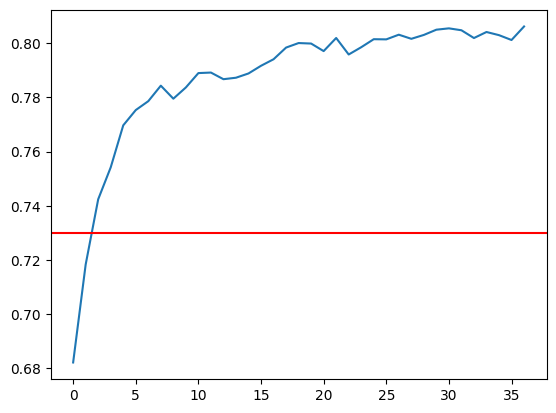

In [ ]:
import matplotlib.pyplot as plt

plt.plot(rocauc[:-11])    # Remove epochs past early stopping cutoff
plt.axhline(y = 0.734, color = 'r', linestyle = '-')    # Baseline 3-layer GNN

plt.show()

# Test Prediction

In [ ]:
test_pred = []

for batch in test_loader:
  batch = batch.to(device)
  if batch.x.shape[0] == 1:
    pass
  else:
    with torch.no_grad():
      pred = model(batch)
      test_pred.append(pred)

test_pred = torch.cat(test_pred, dim = 0).numpy()

In [ ]:
test_pred

array([[ 1.6292285 , -0.23493072, -3.0055606 , ..., -3.2048943 ,
        -2.7196147 ,  1.0162468 ],
       [ 0.1801331 , -0.85364926, -0.08474351, ...,  0.1902895 ,
        -0.4636457 , -0.09180632],
       [-2.1030312 , -3.895368  , -2.0756087 , ..., -2.1170232 ,
        -1.0297955 , -1.514272  ],
       ...,
       [ 0.9162155 ,  0.34449747,  0.51312476, ..., -0.8439136 ,
         1.140546  ,  0.9212615 ],
       [-1.5137254 , -2.8657966 , -5.347151  , ..., -5.089063  ,
        -6.1612144 , -4.820938  ],
       [-1.7174512 , -2.667624  , -1.5598218 , ..., -2.8120942 ,
        -2.170642  ,  0.4246536 ]], dtype=float32)

In [ ]:
pd.DataFrame(test_pred).to_csv('test_output.csv', index=False, header=False)

# Hyperparameter Optimization

In [ ]:
!pip install skorch

## Define Model Wrappers

In [ ]:
from sklearn.base import BaseEstimator
import warnings

warnings.filterwarnings("ignore")   # Suppress VisibleDeprecationWarning

# Wrapper for GCN model
class GCNWrapper(BaseEstimator):
    def __init__(self, hidden_channels, num_node_features, num_classes, lr, batch_size, dropout):
        self.hidden_channels = hidden_channels
        self.num_node_features = num_node_features
        self.num_classes = num_classes
        self.lr = lr
        self.batch_size = batch_size
        self.dropout = dropout

    def fit(self, X, y):
        train_loader = X
        val_loader = y

        # Initialize the model
        model = GCN(
            hidden_channels=self.hidden_channels,
            num_node_features=self.num_node_features,
            num_classes=self.num_classes,
            dropout = self.dropout
        )

        # Loss function and optimizer
        optimizer = optim.Adam(model.parameters(), lr=self.lr, weight_decay=1e-5)
        criterion = nn.BCEWithLogitsLoss(reduction = "none")
        stopper = Early_Stopper(10)

        # Training loop
        for epoch in range(1, 100):
            model.train()

            for step, batch in enumerate(train_loader):
                batch = batch.to(device)
                pred = model(batch)
                y_batch = batch.y.view(pred.shape).to(torch.float64)

                optimizer.zero_grad()
                is_labeled = batch.y == batch.y
                loss = criterion(pred.to(torch.float32)[is_labeled], y_batch.to(torch.float32)[is_labeled]).mean()
                loss.backward()
                optimizer.step()
            val_acc = eval(model, device, val_loader)
            if stopper.early_stop(val_acc['rocauc']):
              break
        train_acc = eval(model, device, train_loader)
        val_acc = eval(model, device, val_loader)
        print({"epochs":epoch,'Lr':self.lr,'dropout':self.dropout,'Train': train_acc, 'Validation': val_acc})
        return val_acc['rocauc']

    def predict(self, X):
        model.eval()
        y_true = []
        y_pred = []

        # For every batch in test loader
        for batch in X:
          batch = batch.to(device)
          if batch.x.shape[0] == 1:
              pass
          else:
              with torch.no_grad():
                  pred = model(batch)
                  y_true.append(batch.y.view(pred.shape))
                  y_pred.append(pred)

        y_true = torch.cat(y_true, dim = 0).numpy()
        y_pred = torch.cat(y_pred, dim = 0).numpy()

        # Compute the ROC - AUC score and store as history
        rocauc_list = []

        for i in range(y_true.shape[1]):
            #AUC is only defined when there is at least one positive data.
            if np.sum(y_true[:,i] == 1) > 0 and np.sum(y_true[:,i] == 0) > 0:
                # ignore nan values
                is_labeled = y_true[:,i] == y_true[:,i]
                rocauc_list.append(roc_auc_score(y_true[is_labeled,i], y_pred[is_labeled,i]))
        return y_true, y_pred


# Wrapper for GAT model
class GATWrapper(BaseEstimator):
    def __init__(self, hidden_channels, num_node_features, num_classes, lr, batch_size, num_heads, dropout, internal_dropout, embedding_size):
        self.hidden_channels = hidden_channels
        self.num_node_features = num_node_features
        self.num_classes = num_classes
        self.lr = lr
        self.batch_size = batch_size
        self.dropout = dropout
        self.num_heads = num_heads
        self.internal_dropout = internal_dropout
        self.embedding_size = embedding_size

    def fit(self, X, y):
        train_loader = X
        val_loader = y

        # Initialize the model
        model = GAT(
            hidden_channels=self.hidden_channels,
            num_node_features=self.num_node_features,
            num_classes=self.num_classes,
            heads = self.num_heads,
            dropout = self.dropout,
            internal_dropout = self.internal_dropout,
            embedding_size = self.embedding_size
        )

        # Loss function and optimizer
        optimizer = optim.Adam(model.parameters(), lr=self.lr, weight_decay=1e-5)
        criterion = nn.BCEWithLogitsLoss(reduction = "none")
        stopper = Early_Stopper(10)

        # Training loop
        for epoch in range(1, 100):
            model.train()

            for step, batch in enumerate(train_loader):
                batch = batch.to(device)
                pred = model(batch)
                y_batch = batch.y.view(pred.shape).to(torch.float64)

                optimizer.zero_grad()
                is_labeled = batch.y == batch.y
                loss = criterion(pred.to(torch.float32)[is_labeled], y_batch.to(torch.float32)[is_labeled]).mean()
                loss.backward()
                optimizer.step()
            val_acc = eval(model, device, val_loader)
            if stopper.early_stop(val_acc['rocauc']):
              break
        train_acc = eval(model, device, train_loader)
        val_acc = eval(model, device, val_loader)
        print({"epochs":epoch,'heads:':self.num_heads,'internal_dropout':self.internal_dropout,'embedding_size':self.embedding_size,'Train': train_acc, 'Validation': val_acc})
        return val_acc['rocauc']

    def predict(self, X):
        model.eval()
        y_true = []
        y_pred = []

        # For every batch in test loader
        for batch in X:
          batch = batch.to(device)
          if batch.x.shape[0] == 1:
              pass
          else:
              with torch.no_grad():
                  pred = model(batch)
                  y_true.append(batch.y.view(pred.shape))
                  y_pred.append(pred)

        y_true = torch.cat(y_true, dim = 0).numpy()
        y_pred = torch.cat(y_pred, dim = 0).numpy()

        # Compute the ROC - AUC score and store as history
        rocauc_list = []

        for i in range(y_true.shape[1]):
            #AUC is only defined when there is at least one positive data.
            if np.sum(y_true[:,i] == 1) > 0 and np.sum(y_true[:,i] == 0) > 0:
                # ignore nan values
                is_labeled = y_true[:,i] == y_true[:,i]
                rocauc_list.append(roc_auc_score(y_true[is_labeled,i], y_pred[is_labeled,i]))
        return y_true, y_pred

## Perform Grid Search

In [ ]:
from itertools import product
from sklearn.metrics import roc_auc_score

def score(y_true, y_pred):
  rocauc_list = []
  for i in range(y_true.shape[1]):
            #AUC is only defined when there is at least one positive data.
            if np.sum(y_true[:,i] == 1) > 0 and np.sum(y_true[:,i] == 0) > 0:
                # ignore nan values
                is_labeled = y_true[:,i] == y_true[:,i]
                rocauc_list.append(roc_auc_score(y_true[is_labeled,i], y_pred[is_labeled,i]))
  return sum(rocauc_list)/len(rocauc_list)

# Define the hyperparameter grid
param_grid = {
    'hidden_channels': [128],  # [16, 32, 64]
    'num_node_features': [9],
    'num_classes': [12],
    'lr': [0.0001],
    'batch_size': [64],
    'num_heads' : [5, 6],
    'dropout': [0.3],
    'internal_dropout': [(0.2,0.2,0.2),(0.3,0.3,0.3)],
    'embedding_size': [100,150,200]
    }

# Convert the param_grid into a list of dictionaries
param_combinations = [dict(zip(param_grid, v)) for v in product(*param_grid.values())]

best_score = float('-inf')
best_params = None

for params in param_combinations:
    # Instantiate the model with specific hyperparameters
    model_gs = GATWrapper(**params)

    # Train and evaluate the model
    rocauc = model_gs.fit(X=train_loader,y=val_loader)

    # Update best parameters if the current combination is better
    if rocauc > best_score:
        best_score = rocauc
        best_params = params

# Print the best parameters and score
print("Best parameters found: ", best_params)
print("Best ROC-AUC score: ", best_score)


{'epochs': 56, 'heads:': 5, 'internal_dropout': (0.2, 0.2, 0.2), 'embedding_size': 100, 'Train': {'rocauc': 0.9243208063603591}, 'Validation': {'rocauc': 0.7887518542900147}}
{'epochs': 77, 'heads:': 5, 'internal_dropout': (0.2, 0.2, 0.2), 'embedding_size': 150, 'Train': {'rocauc': 0.9363512851078784}, 'Validation': {'rocauc': 0.7887786369852022}}
{'epochs': 73, 'heads:': 5, 'internal_dropout': (0.2, 0.2, 0.2), 'embedding_size': 200, 'Train': {'rocauc': 0.9357029156628479}, 'Validation': {'rocauc': 0.7887222301527496}}
{'epochs': 56, 'heads:': 5, 'internal_dropout': (0.3, 0.3, 0.3), 'embedding_size': 100, 'Train': {'rocauc': 0.9243250717171051}, 'Validation': {'rocauc': 0.7879118460718985}}
